In [43]:
import pandas as pd
import os
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Get the list of CSV files in the data folder
data_folder = 'data'
csv_files = [file for file in os.listdir(data_folder) if file.endswith('.csv')]

# Dictionary to store the dataframes
dataframes = {}

# Load each CSV file into a dataframe
for file in csv_files:
    # Create a dataframe name from the file name (removing .csv extension)
    df_name = file.replace('.csv', '')
    
    # Load the dataframe
    file_path = os.path.join(data_folder, file)
    dataframes[df_name] = pd.read_csv(file_path)

# Display the names of the dataframes and their heads
print(f"Found {len(dataframes)} CSV files:")
print("-" * 50)

for df_name, df in dataframes.items():
    print(f"DataFrame name: {df_name}")
    print("-" * 50)
    display(df.head())
    print(f"Shape: {df.shape}")
    print("\n" + "=" * 70 + "\n")

Found 3 CSV files:
--------------------------------------------------
DataFrame name: arabica_data_cleaned
--------------------------------------------------


,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,2,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,3,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,4,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,5,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


Shape: (1311, 44)


DataFrame name: merged_data_cleaned
--------------------------------------------------


,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,0,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,2,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,3,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,4,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


Shape: (1339, 44)


DataFrame name: robusta_data_cleaned
--------------------------------------------------


,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Robusta,ankole coffee producers coop,Uganda,kyangundu cooperative society,NaN,ankole coffee producers,0,ankole coffee producers coop,1488,...,Green,2,"June 26th, 2015",Uganda Coffee Development Authority,e36d0270932c3b657e96b7b0278dfd85dc0fe743,03077a1c6bac60e6f514691634a7f6eb5c85aae8,m,1488.0,1488.0,1488.0
1,2,Robusta,nishant gurjer,India,sethuraman estate kaapi royale,25,sethuraman estate,14/1148/2017/21,kaapi royale,3170,...,NaN,2,"October 31st, 2018",Specialty Coffee Association,ff7c18ad303d4b603ac3f8cff7e611ffc735e720,352d0cf7f3e9be14dad7df644ad65efc27605ae2,m,3170.0,3170.0,3170.0
2,3,Robusta,andrew hetzel,India,sethuraman estate,NaN,NaN,0000,sethuraman estate,1000m,...,Green,0,"April 29th, 2016",Specialty Coffee Association,ff7c18ad303d4b603ac3f8cff7e611ffc735e720,352d0cf7f3e9be14dad7df644ad65efc27605ae2,m,1000.0,1000.0,1000.0
3,4,Robusta,ugacof,Uganda,ugacof project area,NaN,ugacof,0,ugacof ltd,1212,...,Green,7,"July 14th, 2015",Uganda Coffee Development Authority,e36d0270932c3b657e96b7b0278dfd85dc0fe743,03077a1c6bac60e6f514691634a7f6eb5c85aae8,m,1212.0,1212.0,1212.0
4,5,Robusta,katuka development trust ltd,Uganda,katikamu capca farmers association,NaN,katuka development trust,0,katuka development trust ltd,1200-1300,...,Green,3,"June 26th, 2015",Uganda Coffee Development Authority,e36d0270932c3b657e96b7b0278dfd85dc0fe743,03077a1c6bac60e6f514691634a7f6eb5c85aae8,m,1200.0,1300.0,1250.0


Shape: (28, 44)




In [37]:
# List all dataframe names
print("List of all dataframe names:")
for i, name in enumerate(dataframes.keys(), 1):
    print(f"{i}. {name}")

merged_data_cleaned = dataframes['merged_data_cleaned']

List of all dataframe names:
1. arabica_data_cleaned
2. merged_data_cleaned
3. robusta_data_cleaned


In [38]:
# Preprocessing merged_data_cleaned

# 1. Keep only the specified columns
columns_to_keep = ['Species', 'Country.of.Origin', 'Altitude', 'Region', 
                  'Harvest.Year', 'Color', 'Processing.Method', 'Aroma', 
                  'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 
                  'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points', 
                  'Total.Cup.Points', 'Moisture']

merged_data_cleaned = merged_data_cleaned[columns_to_keep]

# 2. Rename columns to replace dots with underscores
merged_data_cleaned.columns = [col.replace('.', '_') for col in merged_data_cleaned.columns]

# 3. Display the total number of records
total_records = len(merged_data_cleaned)
print(f"Total number of records: {total_records}")

# 4. Remove records with NaN or null values and display the count
merged_data_cleaned = merged_data_cleaned.dropna()
records_after_cleaning = len(merged_data_cleaned)
print(f"Number of records after removing NaN/null values: {records_after_cleaning}")
print(f"Removed {total_records - records_after_cleaning} records with missing values")

# Display the first few rows of the cleaned dataframe
merged_data_cleaned.head()

Total number of records: 1339
Number of records after removing NaN/null values: 885
Removed 454 records with missing values


,Species,Country_of_Origin,Altitude,Region,Harvest_Year,Color,Processing_Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean_Cup,Sweetness,Cupper_Points,Total_Cup_Points,Moisture
0,Arabica,Ethiopia,1950-2200,guji-hambela,2014,Green,Washed / Wet,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,8.75,90.58,0.12
1,Arabica,Ethiopia,1950-2200,guji-hambela,2014,Green,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92,0.12
3,Arabica,Ethiopia,1800-2200,oromia,2014,Green,Natural / Dry,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.0,8.67,89.00,0.11
4,Arabica,Ethiopia,1950-2200,guji-hambela,2014,Green,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,88.83,0.12
9,Arabica,Ethiopia,1795-1850,"snnp/kaffa zone,gimbowereda",2014,Green,Natural / Dry,8.08,8.58,8.50,8.50,7.67,8.42,10.0,10.0,10.0,8.50,88.25,0.10


In [39]:
# Precheck for standardization
# List of string columns
string_cols = [
    "Species",
    "Country_of_Origin",
    "Harvest_Year",
    "Color",
    "Processing_Method"
]

# Loop through and print unique values
for col in string_cols:
    print(f"\n--- {col} ---")
    print(merged_data_cleaned[col].unique())
    print(f"Total unique values: {merged_data_cleaned[col].nunique()}")



--- Species ---
['Arabica' 'Robusta']
Total unique values: 2

--- Country_of_Origin ---
['Ethiopia' 'China' 'Costa Rica' 'Mexico' 'Brazil' 'Uganda' 'Taiwan'
 'Kenya' 'Thailand' 'Colombia' 'Panama' 'Guatemala' 'Papua New Guinea'
 'El Salvador' 'Indonesia' 'Tanzania, United Republic Of' 'Honduras'
 'Nicaragua' 'Ecuador' 'United States (Puerto Rico)' 'Haiti' 'Vietnam'
 'Philippines' 'Rwanda' 'Malawi' 'Laos' 'Peru' 'Myanmar' 'Cote d?Ivoire'
 'India' 'United States']
Total unique values: 31

--- Harvest_Year ---
['2014' '2015' '2012' '2011' '2013' '2015/2016' '2017' '2016' '2013/2014'
 '2017 / 2018' '2014/2015' '2011/2012' '2016 / 2017' '2018']
Total unique values: 14

--- Color ---
['Green' 'Blue-Green' 'Bluish-Green']
Total unique values: 3

--- Processing_Method ---
['Washed / Wet' 'Natural / Dry' 'Pulped natural / honey'
 'Semi-washed / Semi-pulped' 'Other']
Total unique values: 5


In [40]:
# Fixes
# Country_of_Origin 
merged_data_cleaned["Country_of_Origin"] = merged_data_cleaned["Country_of_Origin"].replace("Cote d?Ivoire", "Ivory Coast")
merged_data_cleaned["Country_of_Origin"] = merged_data_cleaned["Country_of_Origin"].replace("Tanzania, United Republic Of", "Tanzania")

# Harvest_Year
merged_data_cleaned["Harvest_Year"] = merged_data_cleaned["Harvest_Year"].astype(str).str.split("/").str[0].str.strip().astype(int)

# Color
merged_data_cleaned["Color"] = merged_data_cleaned["Color"].replace("Bluish-Green", "Blue-Green")

# Loop through and print unique values
for col in merged_data_cleaned.columns:
    print(f"\n--- {col} ---")
    print(merged_data_cleaned[col].value_counts())
    print(f"Total unique values: {merged_data_cleaned[col].nunique()}")


--- Species ---
Species
Arabica    879
Robusta      6
Name: count, dtype: int64
Total unique values: 2

--- Country_of_Origin ---
Country_of_Origin
Mexico                         164
Guatemala                      148
Colombia                       112
Brazil                          93
Taiwan                          63
Honduras                        47
Costa Rica                      44
Tanzania                        35
Uganda                          24
Kenya                           19
Thailand                        17
China                           16
Ethiopia                        15
Nicaragua                       13
El Salvador                     12
Malawi                          11
Indonesia                       11
Myanmar                          7
India                            5
Vietnam                          4
Philippines                      4
Haiti                            4
United States (Puerto Rico)      4
Laos                             3
Panama     

In [41]:
# Define sensory columns and their tag names
sensory_tags = {
    'Sweetness': 'Sweet',
    'Acidity': 'Sour',
    'Body': 'Full-bodied',
    'Aftertaste': 'Lingering'
}

# Calculate 75th percentile (top 25%) cutoff for each column
cutoffs = merged_data_cleaned[list(sensory_tags.keys())].quantile(0.75)

# Function to assign readable tags based on top 25% cutoffs
def categorize_coffee(row):
    categories = []
    for col, tag in sensory_tags.items():
        if row[col] >= cutoffs[col]:
            categories.append(tag)
    return categories

# Apply to dataframe
merged_data_cleaned['Taste_Categories'] = merged_data_cleaned.apply(categorize_coffee, axis=1)

print(merged_data_cleaned['Taste_Categories'].apply(tuple).unique())
print(merged_data_cleaned['Taste_Categories'].value_counts())


[('Sweet', 'Sour', 'Full-bodied', 'Lingering')
 ('Sweet', 'Sour', 'Lingering') ('Sour', 'Full-bodied', 'Lingering')
 ('Sweet', 'Sour', 'Full-bodied') ('Sweet', 'Full-bodied', 'Lingering')
 ('Sweet', 'Lingering') ('Sweet', 'Sour') ('Sweet',)
 ('Sweet', 'Full-bodied') ('Full-bodied', 'Lingering')
 ('Sour', 'Lingering') ('Sour', 'Full-bodied') ('Full-bodied',) ()
 ('Lingering',) ('Sour',)]
Taste_Categories
[Sweet]                                  409
[Sweet, Sour, Full-bodied, Lingering]    140
[Sweet, Sour]                             86
[Sweet, Sour, Lingering]                  44
[Sweet, Sour, Full-bodied]                44
[Sweet, Full-bodied, Lingering]           39
[Sweet, Lingering]                        38
[Sweet, Full-bodied]                      38
[]                                        21
[Sour, Full-bodied, Lingering]             8
[Full-bodied]                              6
[Full-bodied, Lingering]                   4
[Sour, Full-bodied]                        4
[Sour]  

In [42]:
# One hot encoding/Multi label binarization

mlb = MultiLabelBinarizer()
taste_encoded = mlb.fit_transform(merged_data_cleaned['Taste_Categories'])

# Convert back to a dataframe with readable column names
taste_df = pd.DataFrame(taste_encoded, columns=mlb.classes_, index=merged_data_cleaned.index)

# Merge with original dataframe if needed
merged_data_cleaned = pd.concat([merged_data_cleaned, taste_df], axis=1)

taste_df.sum()

Full-bodied    283
Lingering      275
Sour           329
Sweet          838
dtype: int64

C:\Users\rachn\AppData\Local\Temp\ipykernel_8768\1563577213.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.index, y=tag_counts.values, palette="Set2")


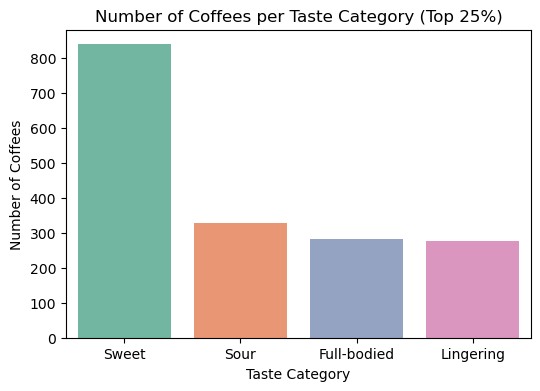

In [44]:
# Count of coffees per tag
tag_counts = merged_data_cleaned['Taste_Categories'].explode().value_counts()

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=tag_counts.index, y=tag_counts.values, palette="Set2")
plt.title("Number of Coffees per Taste Category (Top 25%)")
plt.ylabel("Number of Coffees")
plt.xlabel("Taste Category")
plt.show()

In [49]:
merged_data_cleaned.to_csv('./data/ml_merged_data_cleaned.csv', index=False)